<a href="https://colab.research.google.com/github/pradhap1125/Computer_Vision_Home_Work/blob/main/Computer_Vision_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Computer Vision Homework 3**
**Student Name**: Pradhap Rajamani

**EmailId**: prajaman@pfw.edu

In [1]:
pip install opencv-python numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.5 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy.io
from scipy.ndimage import maximum_filter
from scipy.ndimage import convolve1d, gaussian_filter1d, label, generate_binary_structure

In [3]:
#Parameters for Gaussian smoothing and derivative of gaussian
sigma_values = 1.4
low_thresh=10
high_thresh=100

#parameters for Hough Transform
# Threshold the accumulator to find peaks
rho_res = 1
theta_res = 1
thresholds =  [50, 100, 150]   # votes needed to detect a line
# maximum filter to find local maxima (non-maximum supression)
neighborhood_size = 1


In [4]:
# Derivative of Gaussian kernel
def gaussian_derivative_kernel(size, sigma):
    x = np.arange(-size // 2 + 1, size // 2 + 1)
    kernel = -x * np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(np.abs(kernel))
    return kernel

#Quantizing Gradient Orientation
#reduce the continuous angle values (0–180°) to just four directions, which is needed for non-maximum suppression.
def quantize_angle(theta):
    q_theta = np.zeros_like(theta)
    q_theta[(theta <= 22.5) | (theta > 157.5)] = 0
    q_theta[(theta > 22.5) & (theta <= 67.5)] = 45
    q_theta[(theta > 67.5) & (theta <= 112.5)] = 90
    q_theta[(theta > 112.5) & (theta <= 157.5)] = 135
    return q_theta

# Non-maximum suppression
def non_maximum_suppression(mag, angle):
    suppressed = np.zeros_like(mag)
    rows, cols = mag.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            q = r = 0
            dir = angle[i, j]

            if dir == 0:
                q = mag[i, j+1]
                r = mag[i, j-1]
            elif dir == 45:
                q = mag[i-1, j+1]
                r = mag[i+1, j-1]
            elif dir == 90:
                q = mag[i-1, j]
                r = mag[i+1, j]
            elif dir == 135:
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if mag[i, j] >= q and mag[i, j] >= r:
                suppressed[i, j] = mag[i, j]
            else:
                suppressed[i, j] = 0
    return suppressed

# Hysteresis thresholding
def hysteresis_thresholding(nms_img, low_thresh, high_thresh):
    strong = nms_img >= high_thresh
    weak = (nms_img >= low_thresh) & (nms_img < high_thresh)

    structure = generate_binary_structure(2, 2)
    labels, num_labels = label(weak, structure=structure)

    output = np.zeros_like(nms_img, dtype=np.uint8)
    for i in range(1, num_labels + 1):
        coords = np.where(labels == i)
        if np.any(strong[coords]):
            output[coords] = 255
    output[strong] = 255
    return output

In [5]:
# Load and normalize the image
def load_image(path):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  return img

In [6]:
def canny_edge(path):
    # Load grayscale image
    image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

    size = int(6 * sigma_values) | 1
    #Gaussian smoothing
    smoothed = gaussian_filter1d(image, sigma=sigma_values, axis=0)
    smoothed = gaussian_filter1d(smoothed, sigma=sigma_values, axis=1)

    #Gradient using derivative of Gaussian
    Gx_deriv = gaussian_derivative_kernel(size, sigma_values)
    #derivative (gradient) of the image in the x-direction and y-direction
    Ix = convolve1d(smoothed, Gx_deriv, axis=1)
    Iy = convolve1d(smoothed, Gx_deriv, axis=0)

    #Gradient magnitude and orientation
    magnitude = np.hypot(Ix, Iy)
    #calculates the edge direction (angle) at each pixel
    #converts from radians to degrees
    #% 180: maps angles to the range [0, 180)
    theta = np.rad2deg(np.arctan2(Iy, Ix)) % 180
    q_theta = quantize_angle(theta)
    nms_result = non_maximum_suppression(magnitude, q_theta)

    final_edges = hysteresis_thresholding(nms_result, low_thresh, high_thresh)
    return final_edges


I have used the canny edge detection code which is used in Homework 2 to detect the edges which is needs for hough line detection. Following are the parameters I have used for edge detection

***sigma_values = 1.4***

**low_thresh=10**

***high_thresh=100***

Custom code written for Hough transform is below.

A 2D accumulator array H(θ, ρ) is initialized to zero. Each cell represents a potential line parameterized by angle θ (orientation) and distance ρ (from the origin).

For each edge pixel
(
𝑥
,
𝑦
)
(x,y) detected via an edge detector (custom canny edge), we compute the ρ values for a range of θ values using the equation:

𝜌
=
𝑥
cos
⁡
𝜃
+
𝑦
sin
⁡
𝜃

For each valid
(
𝜃
,
𝜌
)
(θ,ρ) pair, we increment the corresponding cell in the accumulator. This voting process builds up evidence for likely lines.

After voting, the accumulator is scanned for peaks. These peaks correspond to the most prominent lines in the image.

The detected lines are then drawn back onto the image using the inverse polar equation:

𝜌
=
𝑥
cos
⁡
𝜃
+
𝑦
sin
⁡
𝜃

**Parameters:**

**ρ resolution (rho_res) = 1 pixel** (1-pixel steps in the accumulator’s ρ-axis)

low values - Higher precision in line detection

High values - Less precise but faster

θ resolution (**theta_res**) = 1 degree (We used 1° steps across the range [0°, 180°)):

Smaller value - More precise orientation detection

Larger value - Faster, but may skip lines that don't align exactly

**Threshold = 200** (vote threshold for each line)

low value - More lines detected,including weak or noisy ones

high value - less lines detected

**neighborhood_size=5** (size of the window (patch) around each accumulator cell
(
𝜃
,
𝜌
) )




In [7]:
def hough_lines(edges,threshold):
    height, width = edges.shape
    diag_len = int(np.ceil(np.sqrt(width**2 + height**2)))
    rhos = np.arange(-diag_len, diag_len + 1, rho_res)
    thetas = np.deg2rad(np.arange(0, 180, theta_res))  # θ from 0° to 179°

    accumulator = np.zeros((len(thetas), len(rhos)), dtype=np.uint64)

    # Hough voting
    y_idxs, x_idxs = np.nonzero(edges)
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx, theta in enumerate(thetas):
            rho = x * np.cos(theta) + y * np.sin(theta)
            r_idx = int(round((rho + diag_len) / rho_res))  # FIXED
            if 0 <= r_idx < len(rhos):  # safety check
                accumulator[t_idx, r_idx] += 1

    show_hough_lines(accumulator,thetas,rhos)
    max_accumulator = maximum_filter(accumulator, size=neighborhood_size)
    lines = []
    for t_idx in range(len(thetas)):
        for r_idx in range(len(rhos)):
            if accumulator[t_idx, r_idx] > threshold:
              if accumulator[t_idx, r_idx] == max_accumulator[t_idx, r_idx]:
                  rho = rhos[r_idx]
                  theta = thetas[t_idx]
                  lines.append((rho, theta))
    return lines

def show_images_with_lines(lines,img):
    # Draw lines on original image
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    #Show the image with lines
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def show_hough_lines(accumulator, thetas, rhos):
    plt.imshow(accumulator, aspect='auto', cmap='jet', extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    plt.show()


In [8]:
def cv2_hough(path,threshold):
  # Load image and convert to grayscale
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)


    # Apply Hough Line Transform
    lines = cv2.HoughLines(edges, rho=rho_res, theta=np.pi/180, threshold=threshold)

    # Draw detected lines
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Show image in Colab
    cv2_imshow(img)


Result for  Threshold: 50


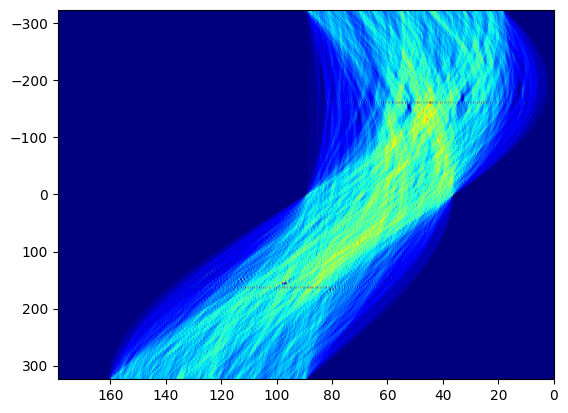

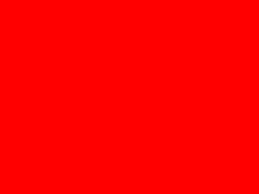

Result for  Threshold: 100


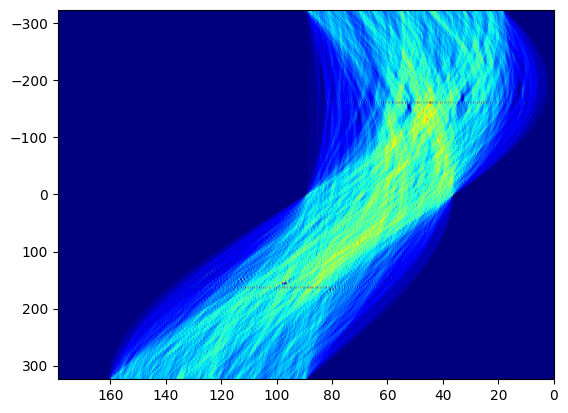

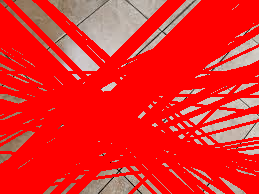

Result for  Threshold: 150


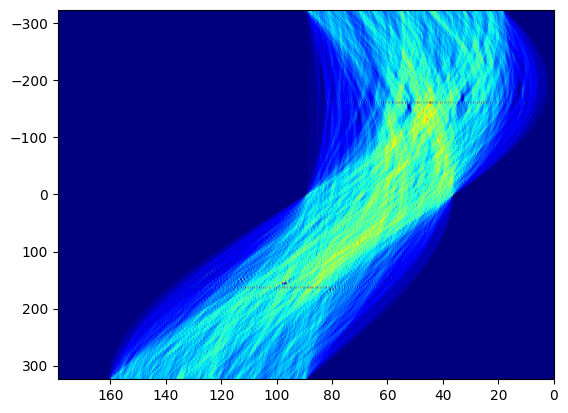

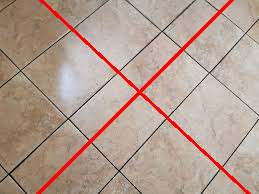

Result for  Threshold: 50


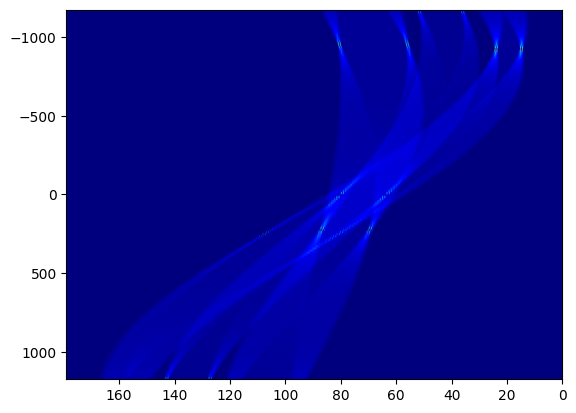

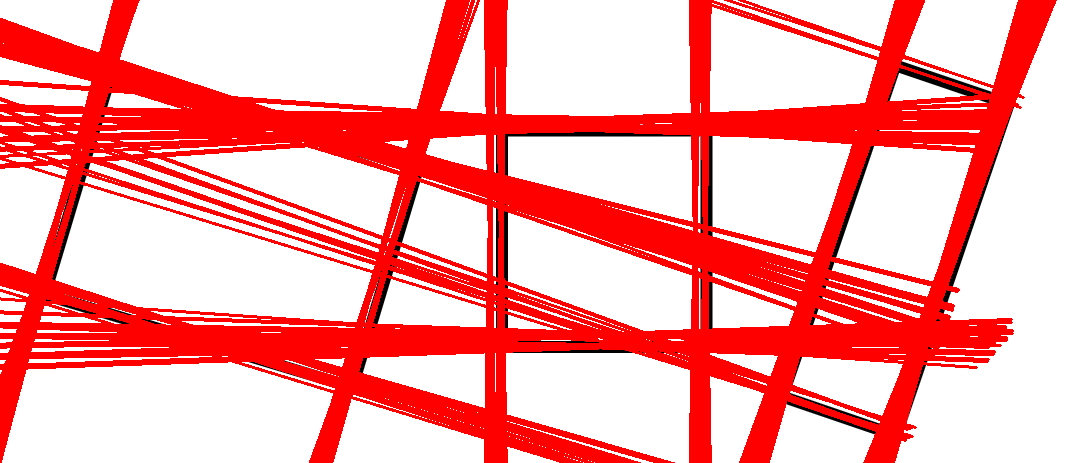

Result for  Threshold: 100


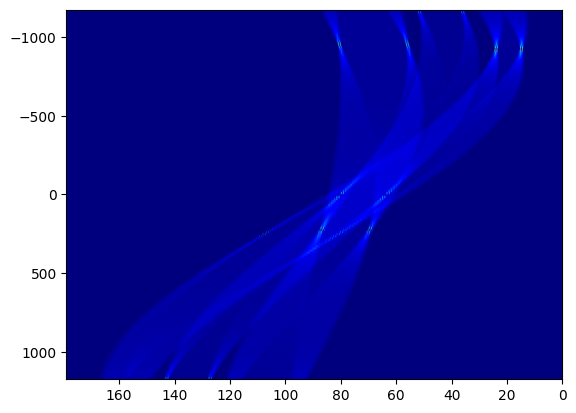

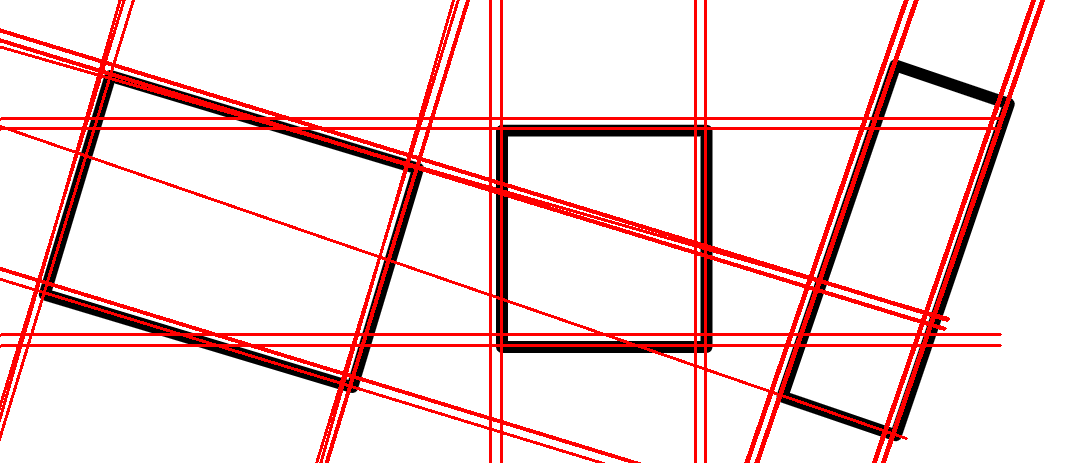

Result for  Threshold: 150


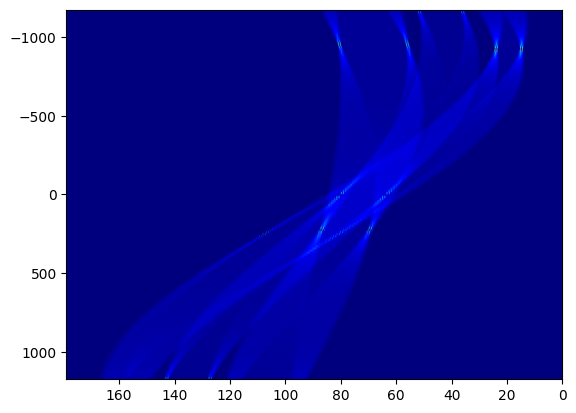

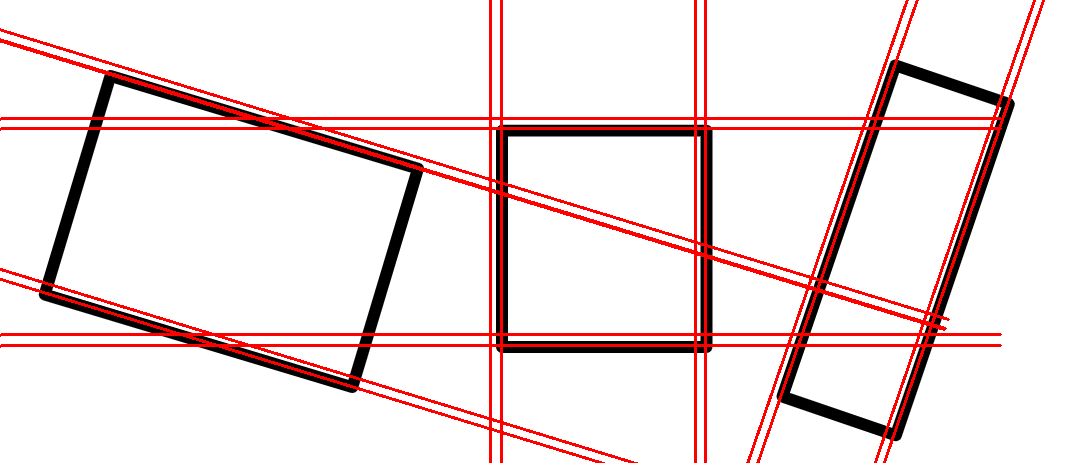

Result for  Threshold: 50


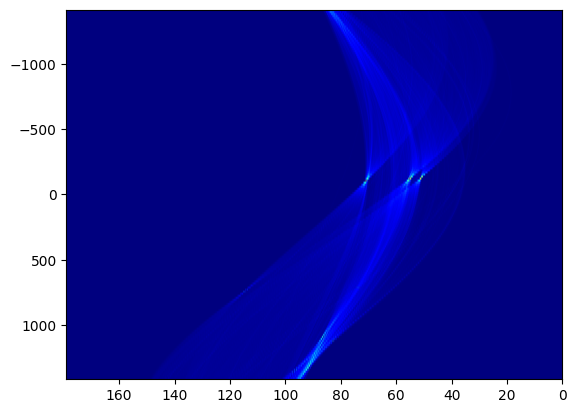

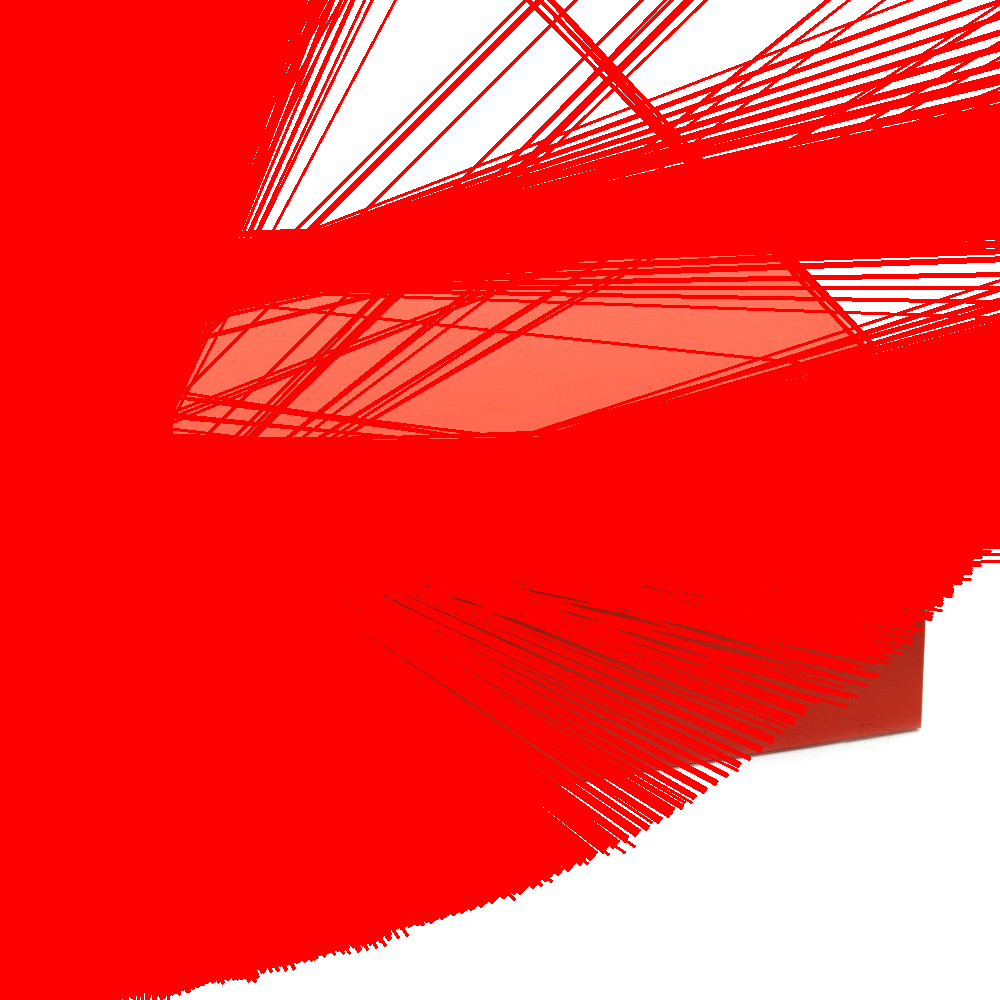

Result for  Threshold: 100


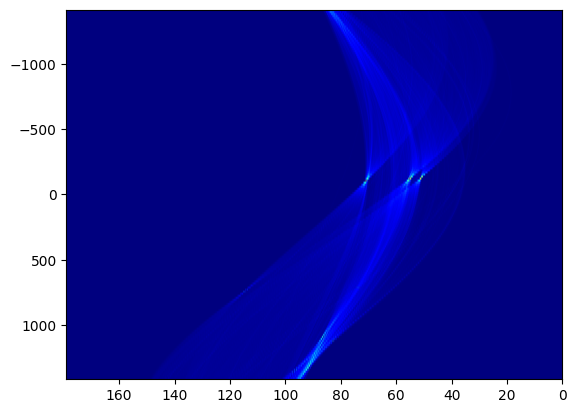

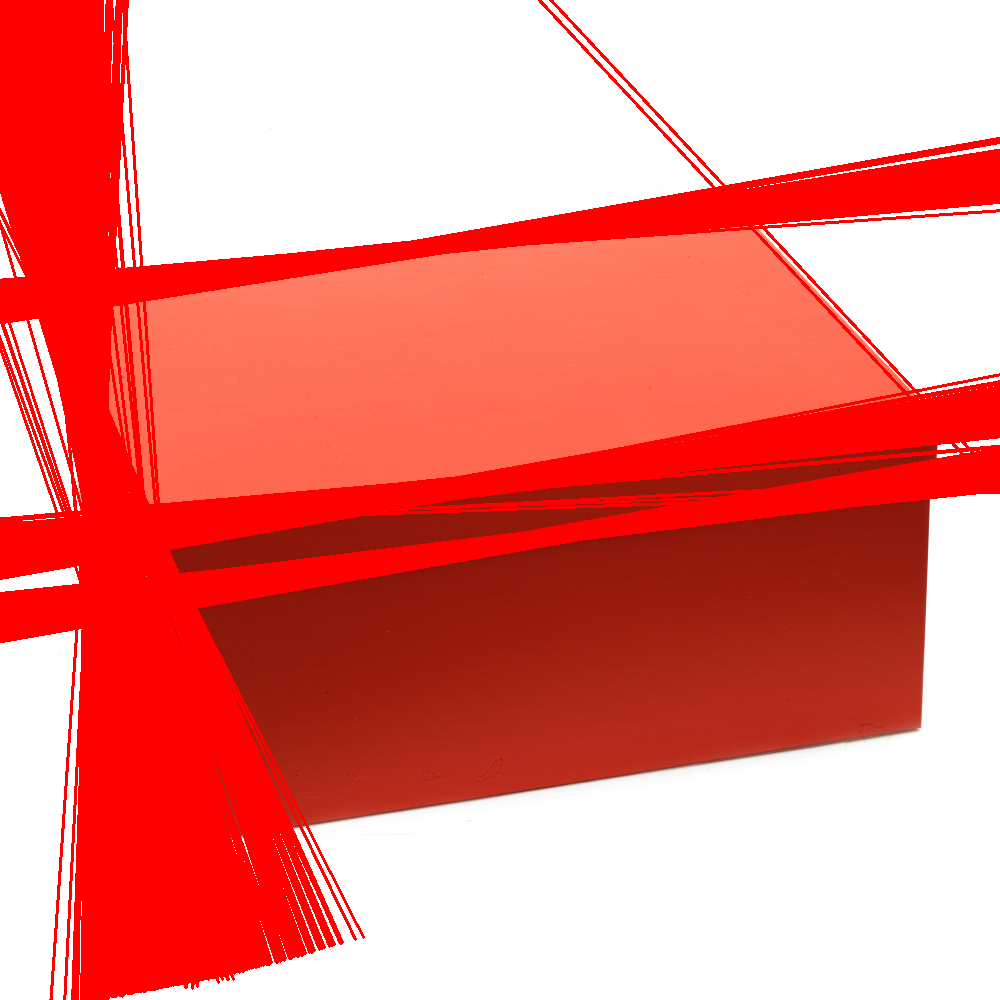

Result for  Threshold: 150


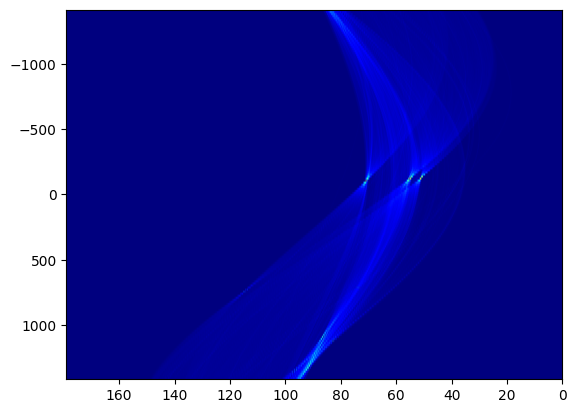

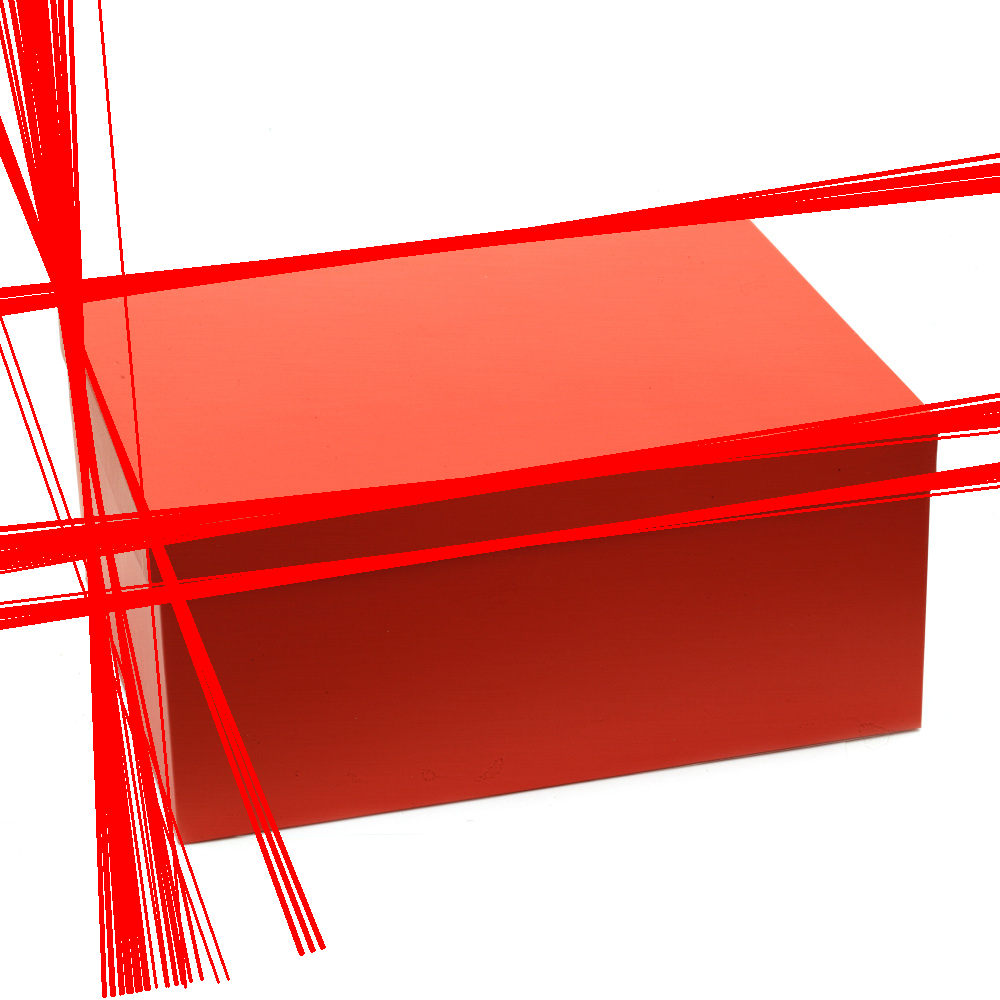

In [9]:
#Load image and detect edges
image_paths=['/content/tiles.jpg','/content/shapes.png','/content/box.jpg']

for path in image_paths:
    for thershold in thresholds:
        print(f"Result for  Threshold: {thershold}")
        img = load_image(path)
        edges = canny_edge(path)
        lines=hough_lines(edges,thershold)
        show_images_with_lines(lines,img)

Result for  Threshold: 50


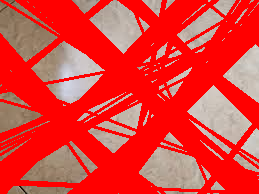

Result for  Threshold: 100


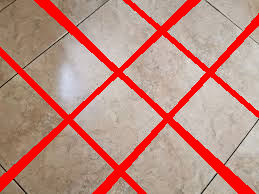

Result for  Threshold: 150


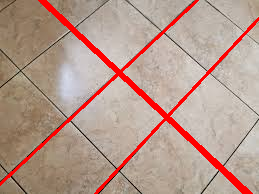

Result for  Threshold: 50


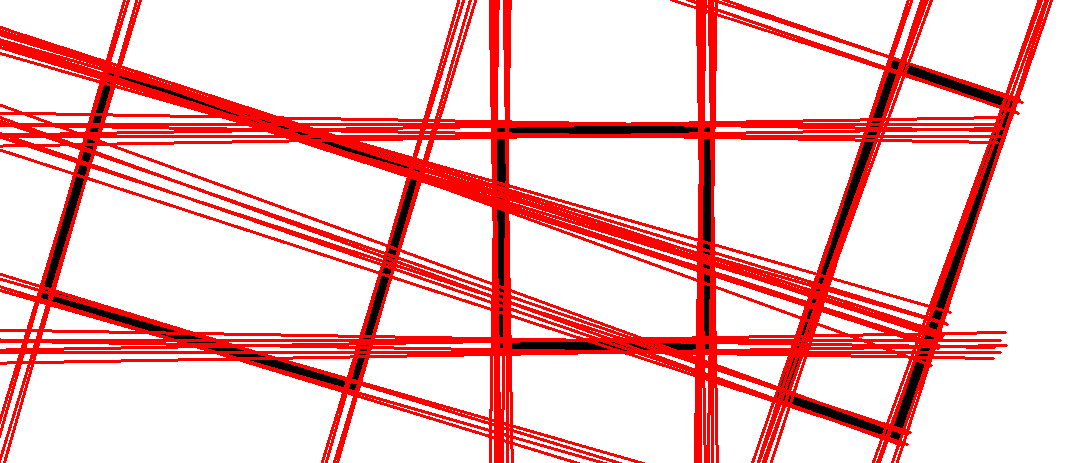

Result for  Threshold: 100


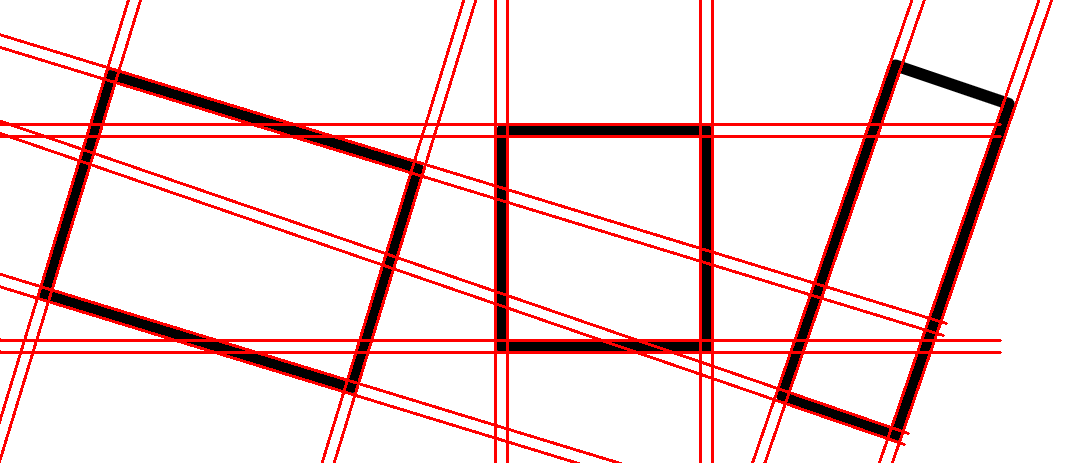

Result for  Threshold: 150


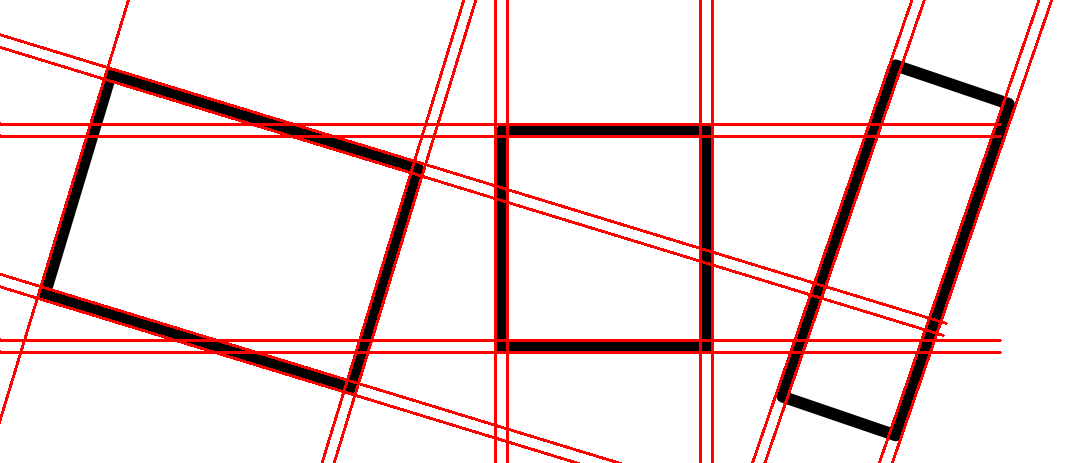

Result for  Threshold: 50


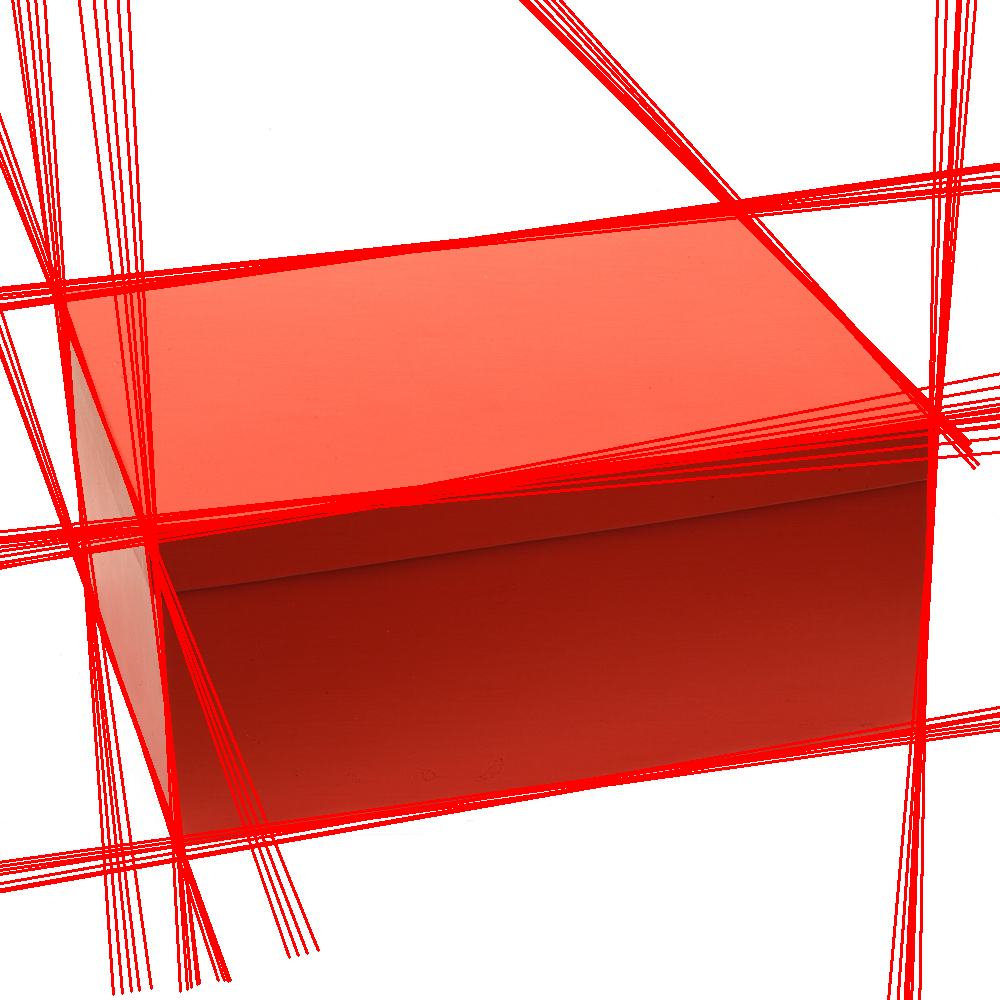

Result for  Threshold: 100


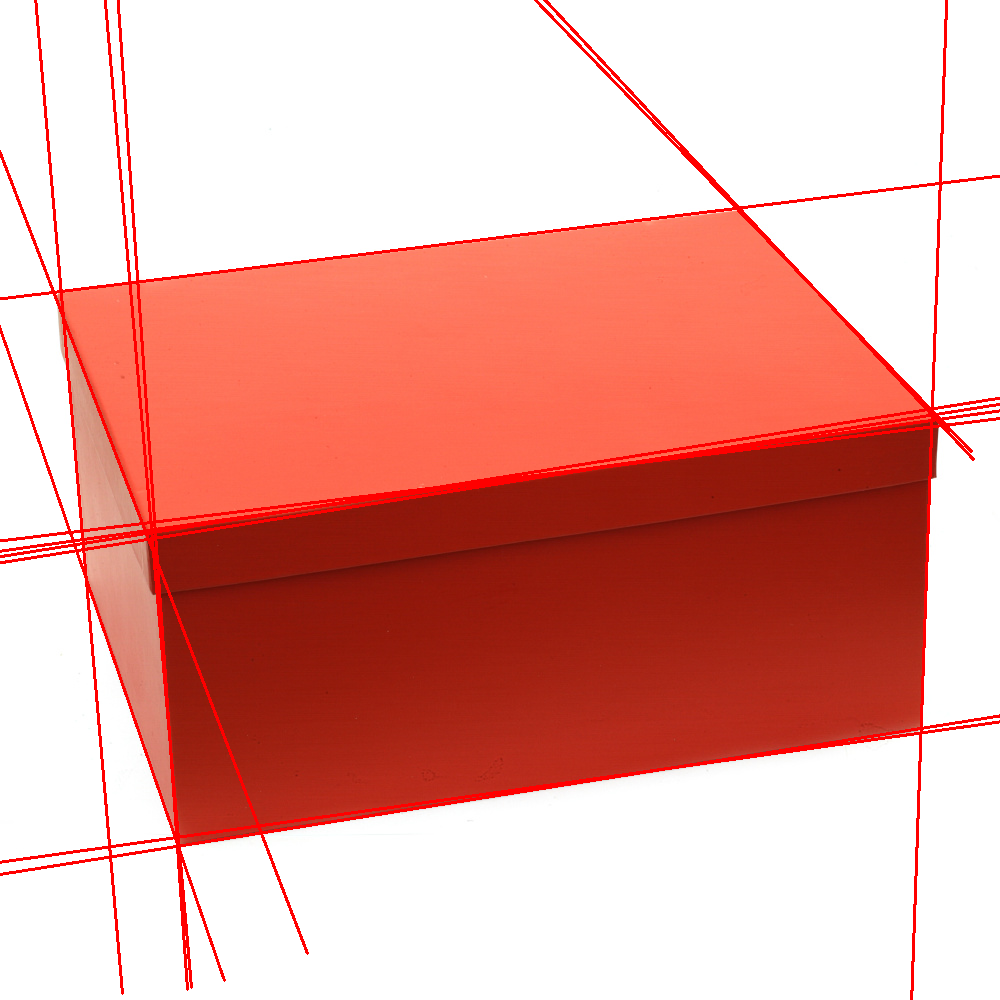

Result for  Threshold: 150


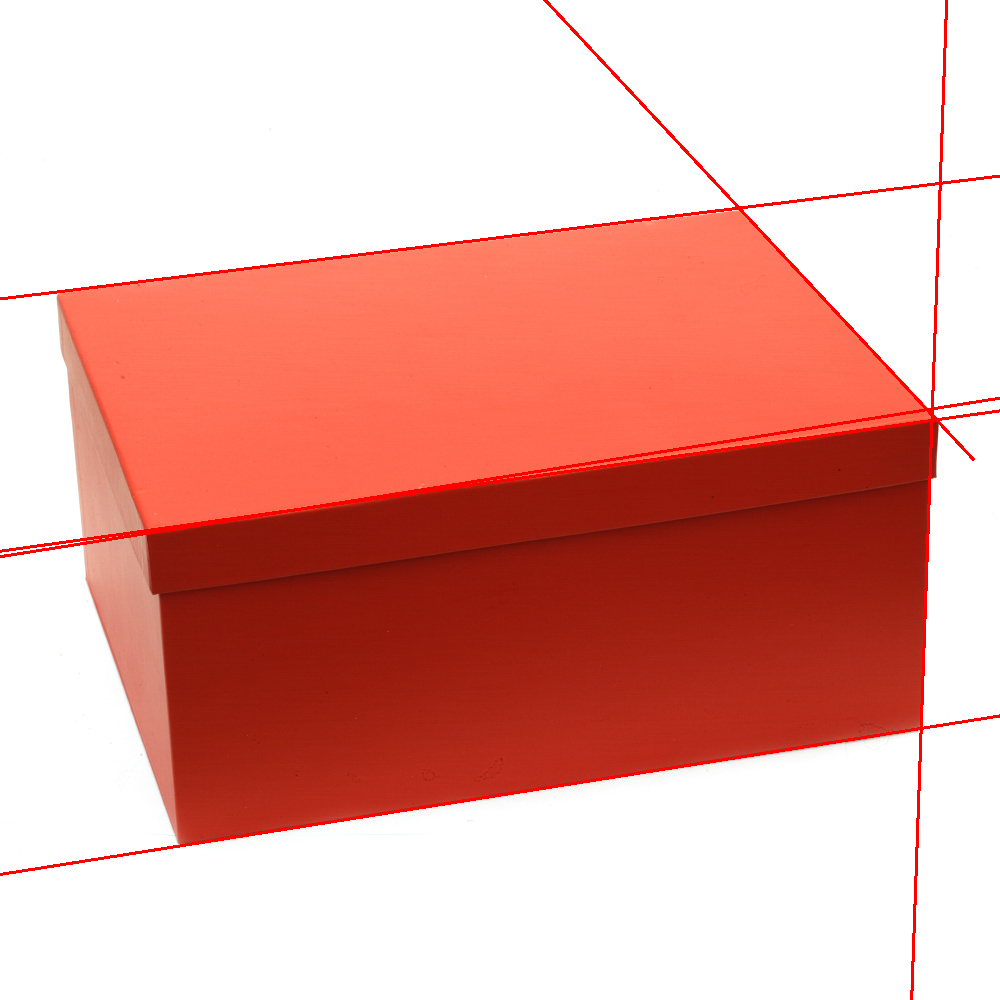

In [10]:
#Load image and detect edges
image_paths=['/content/tiles.jpg','/content/shapes.png','/content/box.jpg']

for path in image_paths:
  for thershold in thresholds:
      print(f"Result for  Threshold: {thershold}")
      cv2_hough(path,thershold)

In this implementation, both a custom approach and OpenCV’s built-in functions were used to perform edge detection using the Canny algorithm and Hough Transform for line detection. The results clearly show that OpenCV’s cv2.HoughLines() method is more effective and efficient in detecting lines compared to the custom implementation.

One key insight is the importance of parameter tuning:

Parameters such as threshold, rho_res (ρ resolution), and theta_res (θ resolution) significantly impact the accuracy of line detection.

There is no one-size-fits-all set of parameters. The values must be adapted to the characteristics of the input image.

To validate this, three different images were tested:

For the tiles image, a threshold of 100 produced optimal results.

For the other two images, a higher threshold of 150 yielded more accurate detections.

This demonstrates that dynamic tuning of these parameters per image is crucial to achieving robust results.

Furthermore, it's believed that the custom implementation can also be improved:

By fine-tuning the parameters (threshold, rho_res, theta_res) specifically for the image.

And by additionally optimizing parameters within the Canny edge detection, such as its low_threshold and high_threshold.

With such enhancements, the custom method can get closer in performance to OpenCV's optimized version